In [142]:
# Import imports XD

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from shap import TreeExplainer, KernelExplainer, initjs, force_plot

In [143]:
# Import data
url = 'https://raw.githubusercontent.com/no-i-in-team/reesh/master/conductors/train.csv'
train = pd.read_csv( url , index_col= 'id' )

# test = pd.read_csv( 'test.csv' , index_col = 'id' )

In [144]:
# Cleanup and wrangle

train.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                          'percent_atom_al' : 'al_atom_p' ,
                          'percent_atom_ga' : 'ga_atom_p' , 
                          'percent_atom_in' : 'in_atom_p' , 
                          'lattice_vector_1_ang' : 'angle_1' ,
                          'lattice_vector_2_ang' : 'angle_2' , 
                          'lattice_vector_3_ang' : 'angle_3' ,
                          'lattice_angle_alpha_degree' : 'angle_a' , 
                          'lattice_angle_beta_degree' : 'angle_b' ,
                          'lattice_angle_gamma_degree' : 'angle_g' ,
                          'formation_energy_ev_natom' : 'f_energy' ,
                          'bandgap_energy_ev' : 'bg_energy' } , inplace = True )

# test.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
#                          'percent_atom_al' : 'al_atom_p' ,
#                          'percent_atom_ga' : 'ga_atom_p' , 
#                          'percent_atom_in' : 'in_atom_p' , 
#                          'lattice_vector_1_ang' : 'ang_1' ,
#                          'lattice_vector_2_ang' : 'ang_2' , 
#                          'lattice_vector_3_ang' : 'and_3' ,
#                          'lattice_angle_alpha_degree' : 'angle_a' , 
#                          'lattice_angle_beta_degree' : 'angle_b' ,
#                          'lattice_angle_gamma_degree' : 'angle_g' } , inplace = True )

def wrangle(df):

    atoms = [ 'al' , 'ga' , 'in' ]
    
# Create new features    
    for elem in atoms:
        df[ f'{ elem }_atoms' ] = df.tot_atom * df[ f'{ elem }_atom_p' ]
    
    df[ 'al_ga_ratio' ] = df.al_atoms / df.ga_atoms
    df[ 'al_in_ratio' ] = df.al_atoms / df.in_atoms
    df[ 'in_ga_ratio' ] = df.in_atoms / df.ga_atoms
    
    redundant = [ 'al_atom_p' , 'ga_atom_p' , 'in_atom_p' ]
# Drop unecessary features    
    for col in redundant:
        df.drop( columns = col , inplace = True )
    
    ratios = [ 'al_ga_ratio' , 'al_in_ratio' , 'in_ga_ratio' ]
# Replace bad values
    for col in ratios:
        df[ col ] = df[ col ].replace( np.inf , np.nan )
        df[ col ] = df[ col ].replace( np.nan , df[ col ].max() )
    
    return df

train = wrangle( train )
# test = wrangle( test )

In [145]:
train.head()

,spacegroup,tot_atom,angle_1,angle_2,angle_3,angle_a,angle_b,angle_g,f_energy,bg_energy,al_atoms,ga_atoms,in_atoms,al_ga_ratio,al_in_ratio,in_ga_ratio
id,,,,,,,,,,,,,,,,
1,33,80.0,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,50.0,30.0,0.0,1.666667,31.051282,0.000000
2,194,80.0,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,50.0,30.0,0.0,1.666667,31.051282,0.000000
3,227,40.0,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,32.5,7.5,0.0,4.333333,31.051282,0.000000
4,167,30.0,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,22.5,0.0,7.5,31.051282,3.000000,31.051282
5,194,80.0,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,0.0,50.0,30.0,0.000000,0.000000,0.600000


In [146]:
# Define targets

target1 = 'bg_energy'
target2 = 'f_energy'

X = train.drop( columns = [ target1 , target2 ] )
# X_test = test

y1 = train[ target1 ]
y2 = train[ target2 ]

In [147]:
# Split data

X1_train, X1_val, y1_train, y1_val = train_test_split( 
    X , y1 , train_size = 0.9 , random_state = 19 )

X2_train, X2_val, y2_train, y2_val = train_test_split( 
    X , y2 , train_size = 0.9 , random_state = 19 )

In [148]:
y1_pred = [y1_train.mean()] * len(y1_train)
y2_pred = [y2_train.mean()] * len(y2_train)

base_mae1 = mean_absolute_error( y1_train , y1_pred )
base_mae2 = mean_absolute_error( y2_train , y2_pred )
def baselines():
    print('Band Gap Energy baseline MAE: ' , base_mae1 )
    print()
    print('Formation Energy baseline MAE: ' , base_mae2 )
 
baselines()

Band Gap Energy baseline MAE:  0.8267515736025377

Formation Energy baseline MAE:  0.08535369444444445


In [149]:
# # Define models and encoders    
# ss = StandardScaler()

# Models
rfr  = RandomForestRegressor( random_state = 19 )
xgbr = XGBRegressor(          random_state = 19 )
r    = Ridge(                 random_state = 19 )
lr   = LinearRegression()

# Fit models to each target 
lr1   = lr.fit(   X1_train , y1_train );    
r1    = r.fit(    X1_train , y1_train );
rfr1  = rfr.fit(  X1_train , y1_train );
xgbr1 = xgbr.fit( X1_train , y1_train );

lr2   = lr.fit(   X2_train , y2_train );
r2    = r.fit(    X2_train , y2_train );
rfr2  = rfr.fit(  X2_train , y2_train );
xgbr2 = xgbr.fit( X2_train , y2_train );

In [150]:
# # # Tuning

# # # Parameter ranges for linear regression...
# fit_intercept = [ True ]
# normalize = [ True ]

# # ...for lr2
# normalize_lr2 = [ False ]

# # ...for ridge
# alpha = np.arange( .1 , 2 , .1 )
# max_iter = np.arange( 1000 , 3000 , 200 )
# solver = [ 'auto' , 'sparse_cg' , 'saga' ]
# normalize_r = [ True , False ]

# # ...for random forest regressor
# n_estimators = np.arange( 100 , 301 , 20 )
# criterion = [ 'mse' , 'mae' ]
# max_depth = np.arange( 1 , 15 , 1 )
# max_features = [ 'auto' , 'sqrt' , 'log2' ]
# bootstrap = [ True ]
# max_samples = np.arange( .3 , 1 , .1 )
# ccp_alpha = np.arange( 0 , 1 , .05)

# # ...and finally xgb regressor
# objective = [ 'reg:squarederror' , 'reg:pseudohubererror' ]
# eta = np.arange( 0 , 1 , .1 ) 
# max_depth_x = np.arange( 1 , 4 , 1 )
# subsample = np.arange( .7 , 1 , .03)
# colsample_bytree = np.arange( .5 , 1 , .05)
# tree_method = [ 'exact' , 'approx' ]
# n_estimators_x = np.arange( 300 , 400 , 10 )
# eval_metric = [ 'rmse' , 'mphe' ]
# reg_lambda = np.arange( 0 , 10 , 1 )
# reg_alpha = np.arange( 0 , 10 , 1 )

# # Organize everything in dictionaries
# params_lr = { 'linearregression__fit_intercept' : fit_intercept ,
#                   'linearregression__normalize' : normalize }
# params_r = {         'ridge__alpha' : alpha ,
#              'ridge__fit_intercept' : fit_intercept ,
#                  'ridge__normalize' : normalize_r ,
#                   'ridge__max_iter' : max_iter ,
#                     'ridge__solver' : solver }
# params_rfr = { 'randomforestregressor__n_estimators' : n_estimators ,
#                   'randomforestregressor__criterion' : criterion ,
#                   'randomforestregressor__max_depth' : max_depth ,
#                'randomforestregressor__max_features' : max_features ,
#                   'randomforestregressor__bootstrap' : bootstrap }
# params_xgbr = {        'xgbregressor__objective' : objective ,
#                              'xgbregressor__eta' : eta ,
#                        'xgbregressor__max_depth' : max_depth_x ,
#                        'xgbregressor__subsample' : subsample ,
#                 'xgbregressor__colsample_bytree' : colsample_bytree ,
#                     'xgbregressor__n_estimators' : n_estimators_x ,
#                     'xgbregressor__tree_method' : tree_method ,               
#                      'xgbregressor__eval_metric' : eval_metric ,
#                      'xgbregressor__reg_lambda' : reg_lambda ,
#                      'xgbregressor__reg_alpha' : reg_alpha }

# # Define randomized search CV models
# rscv_lr1 = RandomizedSearchCV( model_lr1 , 
#                               params_lr ,
#                               n_iter = 2 ,  
#                               n_jobs = -1 , 
#                               verbose = 2 ,
#                               cv = 2 )
# rscv_r1 = RandomizedSearchCV( model_r1 , 
#                              params_r , 
#                              n_iter = 50 ,  
#                              n_jobs = -1 , 
#                              verbose = 2 ,
#                              random_state = 19 ,                            
#                              cv = 3 )
# rscv_rfr1 = RandomizedSearchCV( model_rfr1 , 
#                                params_rfr , 
#                                n_iter = 100 ,  
#                                n_jobs = -1 , 
#                                verbose = 2 ,
#                                random_state = 19 ,                            
#                                cv = 5 )
# rscv_xgbr1 = RandomizedSearchCV( model_xgbr1 , 
#                                 params_xgbr , 
#                                 n_iter = 200 ,  
#                                 n_jobs = -1 , 
#                                 verbose = 2 ,
#                                 random_state = 19 ,                               
#                                 cv = 5 )

# rscv_lr2 = RandomizedSearchCV( model_lr2 , 
#                               params_lr ,
#                               n_iter = 2 ,  
#                               n_jobs = -1 , 
#                               verbose = 2 ,
#                               cv = 2 )
# rscv_r2 = RandomizedSearchCV( model_r2 , 
#                              params_r , 
#                              n_iter = 50 ,  
#                              n_jobs = -1 , 
#                              verbose = 2 ,
#                              random_state = 19 ,                            
#                              cv = 3 )
# rscv_rfr2 = RandomizedSearchCV( model_rfr2 , 
#                                params_rfr , 
#                                n_iter = 100 ,  
#                                n_jobs = -1 , 
#                                verbose = 2 ,
#                                random_state = 19 ,                            
#                                cv = 5 )
# rscv_xgbr2 = RandomizedSearchCV( model_xgbr2 , 
#                                 params_xgbr , 
#                                 n_iter = 200 ,  
#                                 n_jobs = -1 , 
#                                 verbose = 2 ,
#                                 random_state = 19 ,                               
#                                 cv = 5 )

# # Fit RCSV models with training data
# rscv_lr1.fit( X1_train , y1_train );
# rscv_r1.fit( X1_train , y1_train );
# rscv_rfr1.fit( X1_train , y1_train );
# rscv_xgbr1.fit( X1_train , y1_train );

# rscv_lr2.fit( X2_train , y2_train );
# rscv_r2.fit( X2_train , y2_train );
# rscv_rfr2.fit( X2_train , y2_train );
# rscv_xgbr2.fit( X2_train , y2_train );

In [151]:
# # Inspect best parameters

# all_models = [ rscv_lr1 , rscv_r1 , rscv_rfr1 , rscv_xgbr1 , 
#               rscv_lr2 , rscv_r2 , rscv_rfr2 , rscv_xgbr2 ]

# for mod in all_models:
#     print( mod.best_params_ )
#     print()

In [152]:
# Re-define and fit models with best parameters
lr1_tuned = LinearRegression( fit_intercept = True ,
                                  normalize = True )
lr2_tuned = LinearRegression( fit_intercept = True ,
                                  normalize = True )

r1_tuned = Ridge(  random_state = 19 , 
                         solver = 'sparse_cg' , 
                      normalize = False , 
                       max_iter = 1800 ,
                  fit_intercept = True , 
                          alpha = 1.5 )
r2_tuned = Ridge(  random_state = 19 , 
                         solver = 'auto' , 
                      normalize = False , 
                       max_iter = 1200 ,
                  fit_intercept = True , 
                          alpha = 0.5 )

rfr1_tuned = RandomForestRegressor( random_state = 19 ,
                                    n_estimators = 240 ,
                                    max_features = 'log2' ,
                                       max_depth = 10 ,
                                       criterion = 'mae' ,
                                       bootstrap = True )
rfr2_tuned = RandomForestRegressor( random_state = 19 ,
                                    n_estimators = 240 ,
                                    max_features = 'auto' ,
                                       max_depth = 8 ,
                                       criterion = 'mae' ,
                                       bootstrap = True )

xgbr1_tuned = XGBRegressor(     random_state = 19 ,
                                 tree_method = 'exact' ,
                                   subsample = 0.76 ,
                                  reg_lambda = 0 ,
                                   reg_alpha = 2 ,
                                   objective = 'reg:squarederror' ,
                                n_estimators = 330 ,
                                   max_depth = 2 ,
                                 eval_metric = 'mphe' , # if unexpected error, delete this parameter
                                         eta = 0.8 ,
                            colsample_bytree = 0.75 )
xgbr2_tuned = XGBRegressor(     random_state = 19 ,
                                 tree_method = 'exact' ,
                                   subsample = 0.7 ,
                                  reg_lambda = 1 ,
                                   reg_alpha = 1 ,
                                   objective = 'reg:squarederror' ,
                                n_estimators = 310 ,
                                   max_depth = 3 ,
                                 eval_metric = 'mphe' , # if unexpected error, delete this parameter 
                                         eta = 0.2 ,
                            colsample_bytree = 0.85 )

# Fit new models 
lr1_tuned.fit(   X1_train , y1_train );
r1_tuned.fit(    X1_train , y1_train );
rfr1_tuned.fit(  X1_train , y1_train );
xgbr1_tuned.fit( X1_train , y1_train );

lr2_tuned.fit(   X2_train , y2_train );
r2_tuned.fit(    X2_train , y2_train );
rfr2_tuned.fit(  X2_train , y2_train );
xgbr2_tuned.fit( X2_train , y2_train );

In [153]:
# Evaluation dataframes

# Band Gap models evaluation dataframes
bg_columns = {       'MAE' : [ lr1 , r1 , rfr1 , xgbr1 ] ,
               'Tuned MAE' : [ lr1_tuned , r1_tuned , rfr1_tuned , xgbr1_tuned ] ,
                     'R^2' : [ lr1 , r1 , rfr1 , xgbr1 ], 
               'Tuned R^2' : [ lr1_tuned , r1_tuned , rfr1_tuned , xgbr1_tuned ] }

bg_tscores = pd.DataFrame(  data = bg_columns ,
                           index = [ 'lr_train' , 'r_train' , 'rfr_train' , 'xgbr_train' ] )
bg_vscores = pd.DataFrame(  data = bg_columns ,
                           index = [ 'lr_val' , 'r_val' , 'rfr_val' , 'xgbr_val' ] )

# Formation models evaluation dataframes
f_columns  = {       'MAE' : [ lr2 , r2 , rfr2 , xgbr2 ] ,
               'Tuned MAE' : [ lr2_tuned , r2_tuned , rfr2_tuned , xgbr2_tuned ] ,
                     'R^2' : [ lr2 , r2 , rfr2 , xgbr2 ], 
               'Tuned R^2' : [ lr2_tuned , r2_tuned , rfr2_tuned , xgbr2_tuned ] }

f_tscores = pd.DataFrame( data = f_columns ,
                         index = [ 'lr_train' , 'r_train' , 'rfr_train' , 'xgbr_train' ] )
f_vscores = pd.DataFrame( data = f_columns ,
                         index = [ 'lr_val' , 'r_val' , 'rfr_val' , 'xgbr_val' ] )

In [154]:
# Band Gap score functions
def bgmae_train( mod ):
      score = mean_absolute_error( y1_train , mod.predict( X1_train ) )
      return score
def bgmae_val( mod ):
      score = mean_absolute_error( y1_val , mod.predict( X1_val ) )
      return score
def bgr2_train( mod ):
      score = mod.score( X1_train , y1_train )
      return score
def bgr2_val( mod ):
      score = mod.score( X1_val , y1_val )
      return score

# Formation score functions
def fmae_train( mod ):
      score = mean_absolute_error( y2_train , mod.predict( X2_train ) )
      return score
def fmae_val( mod ):
      score = mean_absolute_error( y2_val , mod.predict( X2_val ) )
      return score
def fr2_train( mod ):
      score = mod.score( X2_train , y2_train )
      return score
def fr2_val( mod ):
      score = mod.score( X2_val , y2_val )
      return score

In [155]:
mae_cols = [ 'MAE' , 'Tuned MAE' ]
r2_cols = [ 'R^2' , 'Tuned R^2' ]

# Scores using training data  

for col in mae_cols:
    bg_tscores[ col ] = bg_tscores[ col ].apply( bgmae_train )
for col in r2_cols:
    bg_tscores[ col ] = bg_tscores[ col ].apply( bgr2_train )

for col in mae_cols:
    f_tscores[ col ] = f_tscores[ col ].apply( fmae_train )
for col in r2_cols:
    f_tscores[ col ] = f_tscores[ col ].apply( fr2_train )

# now using validation data

for col in mae_cols:
    bg_vscores[ col ] = bg_vscores[ col ].apply( bgmae_val )
for col in r2_cols:
    bg_vscores[ col ] = bg_vscores[ col ].apply( bgr2_val )
    
for col in mae_cols:
    f_vscores[ col ] = f_vscores[ col ].apply( fmae_val )
for col in r2_cols:
    f_vscores[ col ] = f_vscores[ col ].apply( fr2_val )

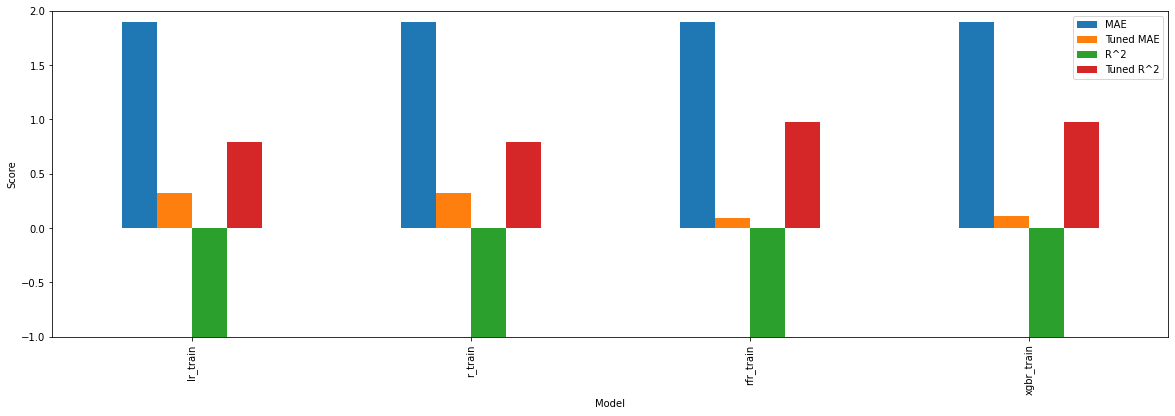

In [156]:
bgts_plot = bg_tscores.plot.bar( ylim = ( -1 , 2 ) , 
                                figsize = ( 20 , 6 ) ,
                                ylabel = 'Score' ,
                                xlabel = 'Model' )

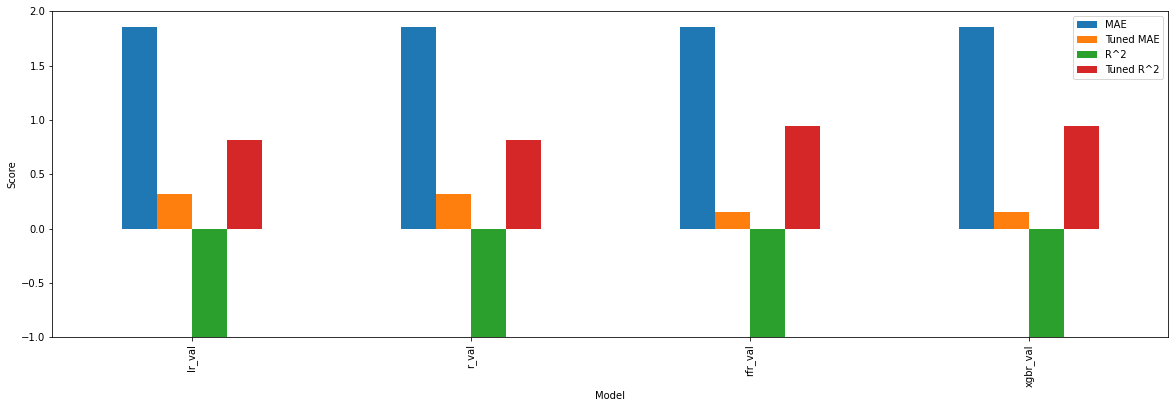

In [157]:
bgvs_plot = bg_vscores.plot.bar( ylim = ( -1 , 2 ) , 
                                figsize = ( 20 , 6 ) ,
                                ylabel = 'Score' ,
                                xlabel = 'Model' )

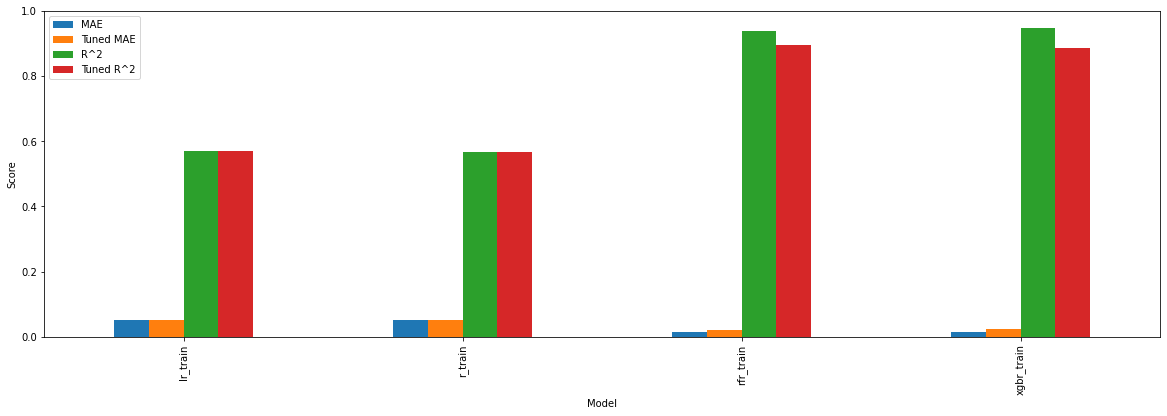

In [158]:
fts_plot = f_tscores.plot.bar( ylim = ( 0 , 1 ) , 
                                figsize = ( 20 , 6 ) ,
                                ylabel = 'Score' ,
                                xlabel = 'Model' )

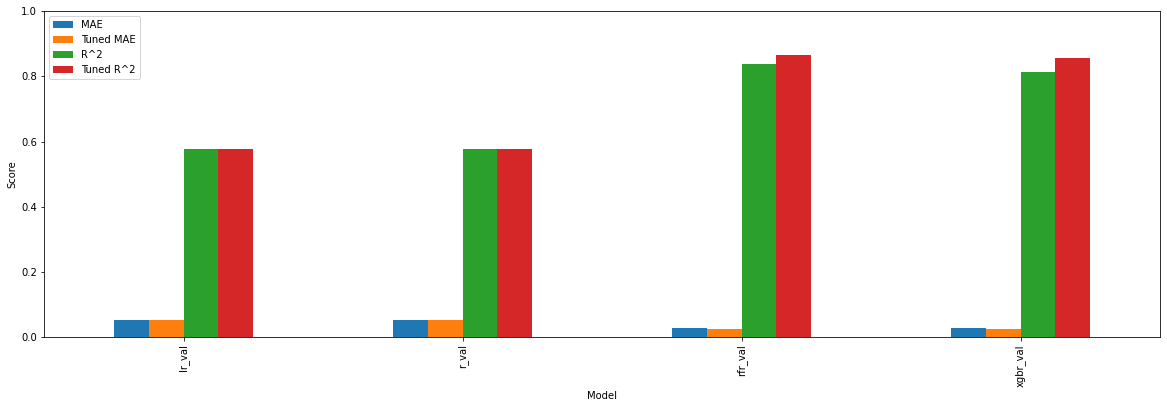

In [159]:
fvs_plot = f_vscores.plot.bar( ylim = ( 0 , 1 ) , 
                                figsize = ( 20 , 6 ) ,
                                ylabel = 'Score' ,
                                xlabel = 'Model' )

<AxesSubplot:title={'center':'Band Gap Energy RFR Feature Importances'}, xlabel='Feature', ylabel='Importance'>

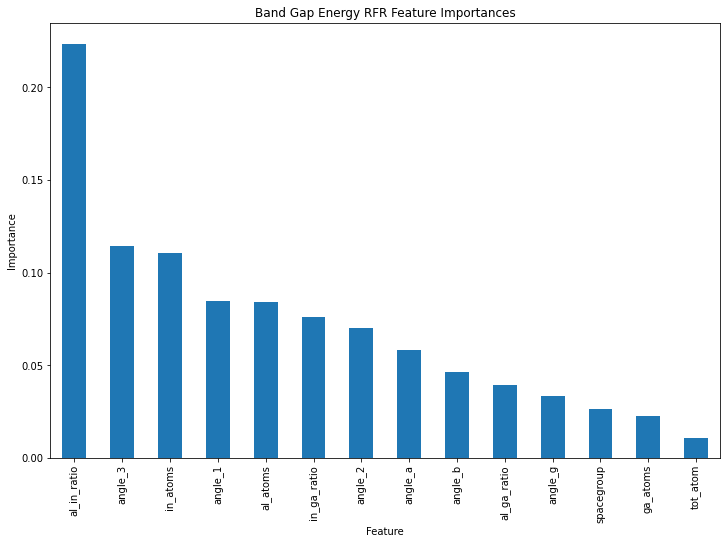

In [169]:
# Visualize feature importances
rfr1_fimp = rfr1_tuned.feature_importances_
rfr2_fimp = rfr2_tuned.feature_importances_

xgbr1_fimp = xgbr1_tuned.feature_importances_
xgbr2_fimp = xgbr2_tuned.feature_importances_

rfr1_importances = pd.Series( rfr1_fimp , index = X1_train.columns )
rfr1_importances.sort_values( ascending = False , inplace = True )
rfr1_importances.plot.bar( figsize = ( 12 , 8 ) ,
                           xlabel = 'Feature' ,
                           ylabel = 'Importance' , 
                           title = 'Band Gap Energy RFR Feature Importances' )

<AxesSubplot:title={'center':'Formation Energy RFR Feature Importances'}, xlabel='Feature', ylabel='Importance'>

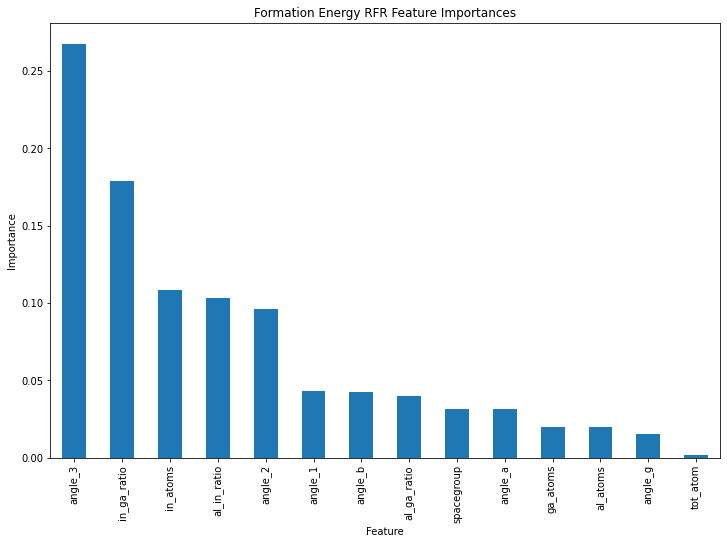

In [170]:
rfr2_importances = pd.Series( rfr2_fimp , index = X2_train.columns )
rfr2_importances.sort_values( ascending = False , inplace = True )
rfr2_importances.plot.bar( figsize = ( 12 , 8 ) ,
                           xlabel = 'Feature' ,
                           ylabel = 'Importance' , 
                           title = 'Formation Energy RFR Feature Importances' )

<AxesSubplot:title={'center':'Band Gap Energy XGBR Feature Importances'}, xlabel='Feature', ylabel='Importance'>

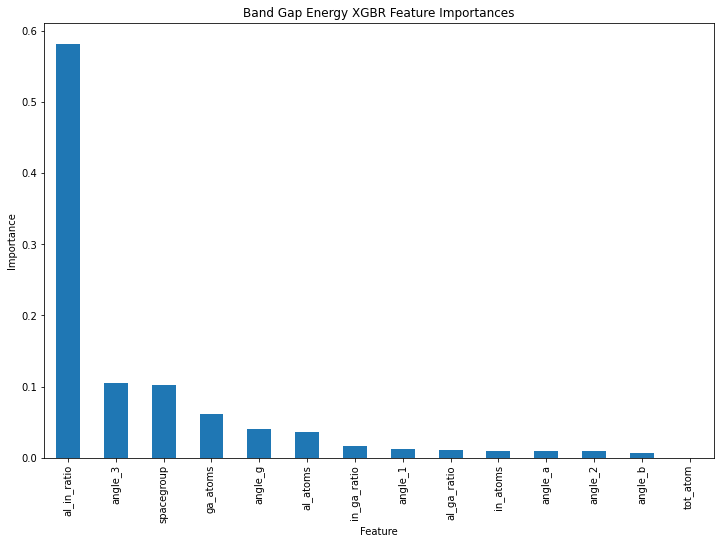

In [171]:
xgbr1_importances = pd.Series( xgbr1_fimp , index = X1_train.columns )
xgbr1_importances.sort_values( ascending = False , inplace = True )
xgbr1_importances.plot.bar( figsize = ( 12 , 8 ) ,
                           xlabel = 'Feature' ,
                           ylabel = 'Importance' , 
                           title = 'Band Gap Energy XGBR Feature Importances' )

<AxesSubplot:title={'center':'Formation Energy XGBR Feature Importances'}, xlabel='Feature', ylabel='Importance'>

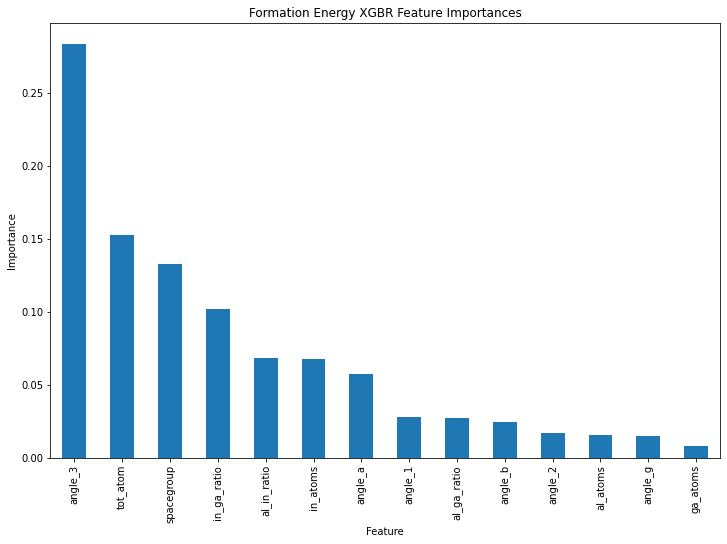

In [172]:
xgbr2_importances = pd.Series( xgbr2_fimp , index = X2_train.columns )
xgbr2_importances.sort_values( ascending = False , inplace = True )
xgbr2_importances.plot.bar( figsize = ( 12 , 8 ) ,
                           xlabel = 'Feature' ,
                           ylabel = 'Importance' , 
                           title = 'Formation Energy XGBR Feature Importances' )

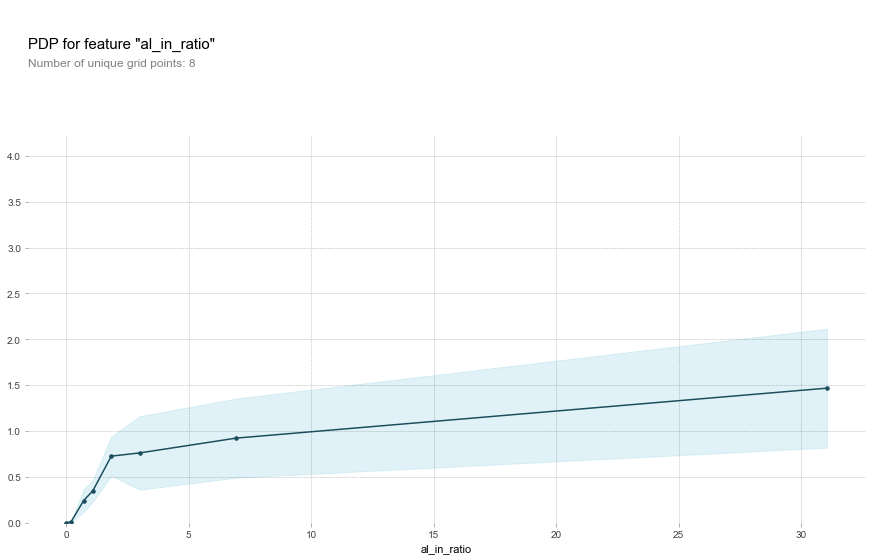

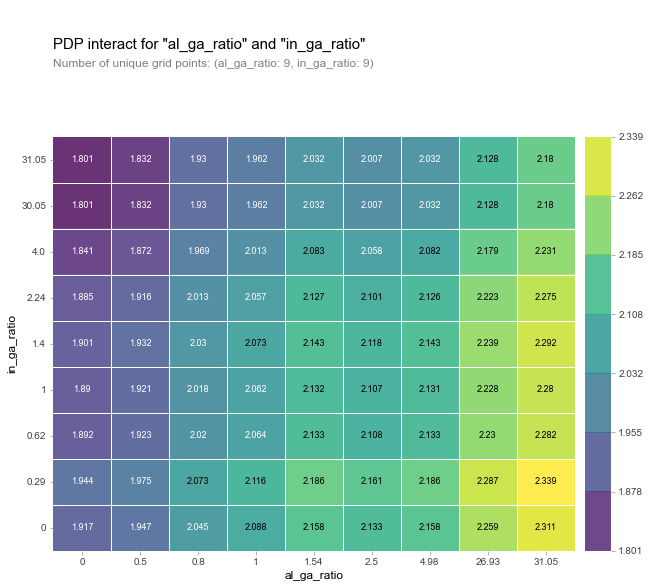

In [164]:
# Band Gap Energy - Visualization of single and double feature importances
feature = 'al_in_ratio'

isolate1 = pdp_isolate( model = xgbr1_tuned ,
                       dataset = X1_val ,
                       model_features = X1_val.columns ,
                       feature = feature )
pdp_plot( isolate1, feature_name = feature );

features = [ 'al_ga_ratio' , 'in_ga_ratio' ]

interact1 = pdp_interact( model = xgbr1_tuned ,
                         dataset = X1_val ,
                         model_features = X1_val.columns ,
                         features = features )
pdp_interact_plot( interact1 , plot_type = 'grid' , feature_names = features , 
                   figsize = ( 10 , 10 ) );

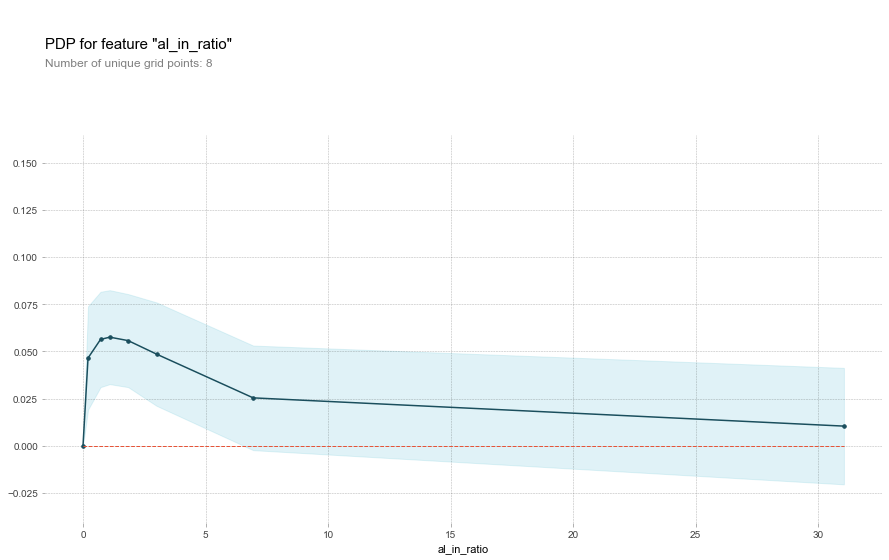

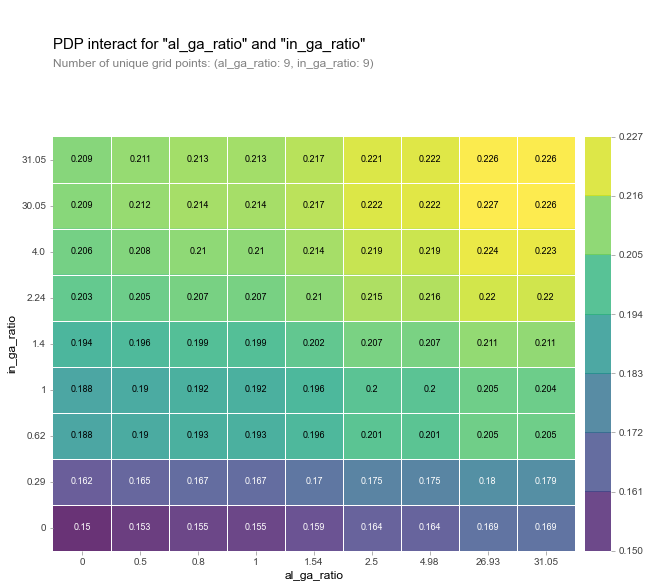

In [165]:
# Formation Energy - Visualization of single and double feature importances 
isolate2 = pdp_isolate( model = xgbr2_tuned ,
                        dataset = X2_val ,
                        model_features = X2_val.columns ,
                        feature = feature )
pdp_plot( isolate2 , feature_name = feature );

interact2 = pdp_interact( model = xgbr2_tuned ,
                          dataset = X2_val ,
                          model_features = X2_val.columns ,
                          features = features )
pdp_interact_plot( interact2 , plot_type = 'grid' , feature_names = features , 
                   figsize = ( 10 , 10 ) );

In [166]:
# More visuals - shap plots

row = X1_val.iloc[ [ 119 ] ]

# exp1 = KernelExplainer( lr1_tuned )
# exp2 = KernelExplainer( lr2_tuned )

# exp3 = KernelExplainer( r1_tuned )
# exp4 = KernelExplainer( r2_tuned )

# exp5 = TreeExplainer( rfr1_tuned )
# exp6 = TreeExplainer( rfr2_tuned )
initjs()

exp7 = TreeExplainer( xgbr1_tuned )
exp8 = TreeExplainer( xgbr2_tuned )

force_plot( base_value = exp7.expected_value ,
           shap_values = exp7.shap_values( row ) ,
              features = row )

In [167]:
initjs()

force_plot( base_value = exp8.expected_value ,
           shap_values = exp8.shap_values( row ) ,
              features = row )